This generates gblocks of designs from fasta files. The clusters can be specified in to 8 or 12 to fit a 96 well plate. 

Take difference between minimum and maximum of design based on name. Next, use kmeans to cluster designs into N-number of
cluster points. 

In [29]:
# input and output file defined here:
# File name of output file
ofile = "20190820_DNA_sequence.fasta"
# inputfile
ifile = "20180926_Elanco_b13G_designs_462.fasta"

In [30]:
import pandas as pd
# parameters needed for the run
## bsaI sites for cloning
preseq = "GTCACGGTCTCA"
postseq = "CGAGACCAGTCA"
# range of basepair offset
bp_offset_nterm = 3
bp_offset_cterm = 3
bp_offset = 12
# envoke print statements
debug = 0
# variable parameter for the gene length
# g-blocks to synthetize
cutoff = [250,500,750,1000]
cluster_size = 16

In [31]:
# prices taken from here (Tubes): 
# https://www.idtdna.com/pages/products/genes-and-gene-fragments/gblocks-gene-fragments
idt_gblock = {
    250 : 71.10,
    500 : 71.10,
    750 : 80.10,
    1000 : 89.10,
    1250 : 143.10
}

In [32]:
def get_price(length):
    ln = int(length)
    if ln <= 250:
        return 71.10
    elif ln <= 500: 
        return 71.10
    elif ln <= 750:
        return 80.10
    elif ln <= 1000:
        return 89.10
    elif ln <= 1250:
        return 143.10
    elif ln <= 1500:
        return 179.1
    else:
        return "Error"

In [33]:
def read_fastafile(ifile):
    sequences = {}
    with open(ifile,'r') as f:
        for line in f:
            if(line[0] == ">"):
                tmp = line.split()
                ids = tmp[0]
                sequences[ids] = ""
            else:
                tmp = line.strip()
                sequences[ids] = sequences[ids] + tmp
    return sequences

In [34]:
def reassign_missing_variants(df):
    '''
    '''
    reassign_cluster = {}
    # sub-divide the rest into exciting cluster
    for i,j,k,c,l in zip(df.index, df["start_DNA_w_padding"], df["end_DNA_w_padding"], df["Clustered"],df["Size_of_gene"]):
        if(c == 0):
            for key in dict_w_start_stop:
                if( (j >= dict_w_start_stop[key][0]) & (k <= dict_w_start_stop[key][1])):
                    # add and sort such that we can add it to the
                    # shortest gene cluster
                    tmpkey = "index_"+str(i)
                    reassign_cluster[tmpkey] = (i,j,k,c,key,dict_w_start_stop[key][2])
    # sort dictionary
    listofTuples = sorted(reassign_cluster.items() ,  key=lambda x: x[-1] )
    r_c = dict(listofTuples)
    for key in reassign_cluster.keys():
        df.iloc[r_c[key][0], df.columns.get_loc("Clustered")] = 1
        df.iloc[r_c[key][0], df.columns.get_loc("Cluster_name")] = r_c[key][4]
        df.iloc[r_c[key][0], df.columns.get_loc("Size_of_gene")] = r_c[key][5]
    return df

In [35]:
sequences = read_fastafile(ifile)
df_sequences = pd.DataFrame.from_dict(sequences,orient='index',columns=['seq(DNA)'] )
df_sequences.reset_index(inplace=True)
df_sequences = df_sequences.rename(columns={'index':'VarName'})

In [36]:
def set_residue_numbers(seq_df):
    # initialize new columns
    seq_df["start_DNA"] = 0 
    seq_df["end_DNA"] = 0 
    # loop over keys in hash
    # Contain all the positions mutated
    residue_nr = []
    # contains residue numbers for each variant
    tmpresiduenr = {}
    for index,varname in zip(seq_df.index,seq_df["VarName"]):
        new_array = []
        nametmp_ = varname[1:].split("_")
        for j in nametmp_:
            new_array.append( int(j[1:-1] ) )
        mn = min(new_array)
        mx = max(new_array)
        # The -3 is due to counting from 0 and protein vs DNA
        seq_df.iloc[index,seq_df.columns.get_loc("start_DNA")] = 3*mn-3
        # 
        seq_df.iloc[index,seq_df.columns.get_loc("end_DNA")] = 3*mx
    return seq_df

In [37]:
df_sequences = set_residue_numbers(df_sequences)
df_sequences["start_DNA_w_padding"] = df_sequences["start_DNA"] - bp_offset
df_sequences["end_DNA_w_padding"] = df_sequences["end_DNA"] + bp_offset

In [38]:
df_sequences.sort_values(by=["start_DNA_w_padding","end_DNA_w_padding"],inplace=True)
df_sequences["length_DNA_w_padding"] = df_sequences["end_DNA_w_padding"] - df_sequences["start_DNA_w_padding"]

In [39]:
df_sequences["Clustered"] = 0
df_sequences["Cluster_name"] = ""
df_sequences["Size_of_gene"] = 0

In [40]:
def get_clusters(df,min_size_cluster,cutoff,gb="start_DNA_w_padding", parameter="length_DNA_w_padding"):
    # remove lengths greater than cutoff
    temp = df[(df[parameter] < cutoff) & (df["Clustered"] != 1) ]
    # count how many 
    tmp_= temp.groupby(gb).count().reset_index()
    # only clusters of certain size are investigated
    tmp_ = tmp_[tmp_["VarName"] >= min_size_cluster]
    return tmp_

def set_clusters(df,init_values, cutoff):
    for i,j,l,c in zip(df.index, df["start_DNA_w_padding"], df["length_DNA_w_padding"],df["Clustered"]):
        
        # bool value so you dont overwrite existing clusters
        if(c == 1):
            continue
        elif((j in init_values) & (l < cutoff)):
            df.iloc[i, df.columns.get_loc("Clustered")] = 1
            df.iloc[i, df.columns.get_loc("Cluster_name")] = "cluster_"+str(j)+"_"+str(j+cutoff)+"_"+str(cutoff)
            df.iloc[i, df.columns.get_loc("Size_of_gene")] = cutoff
        else:
            continue
    return df
min_size_cluster = 3
df_test = df_sequences.copy()
df_test = df_test.reset_index()

In [41]:
df_test.head()

,index,VarName,seq(DNA),start_DNA,end_DNA,start_DNA_w_padding,end_DNA_w_padding,length_DNA_w_padding,Clustered,Cluster_name,Size_of_gene
0,8,>N21I,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,60,63,48,75,27,0,,0
1,9,>N21I_S89F,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,60,267,48,279,231,0,,0
2,17,>V76H,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,225,228,213,240,27,0,,0
3,11,>N246H_V76H,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,225,738,213,750,537,0,,0
4,7,>N169K,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,504,507,492,519,27,0,,0


In [42]:
for i in cutoff:
    test = get_clusters(df_test, min_size_cluster,i)
    if( len(test) != 0):
        init_values = list(test.sort_values(by=["VarName"],ascending=False)["start_DNA_w_padding"])
        df_test = set_clusters(df_test,init_values, i )

In [43]:
min_size_cluster = 1
for i in cutoff:
    test = get_clusters(df_test, min_size_cluster,i)
    if( len(test) != 0):
        init_values = list(test.sort_values(by=["VarName"],ascending=False)["start_DNA_w_padding"])
        df_test = set_clusters(df_test,init_values, i )

In [44]:
tmp = list(set(df_test["Cluster_name"]))
dict_w_start_stop = {}
for i in tmp:
    if(i != ''):
        tmpval = i.strip().split("_")
        dict_w_start_stop[i] = (int(tmpval[1]),int(tmpval[2]),int(tmpval[3]) )

In [45]:
tmp = list(set(df_test["Cluster_name"]))
dict_w_start_stop = {}
for i in tmp:
    if(i != ''):
        tmpval = i.strip().split("_")
        dict_w_start_stop[i] = (int(tmpval[1]),int(tmpval[2]),int(tmpval[3]) )      
df_test = reassign_missing_variants(df_test)

In [46]:
cutoff = [1250, 1500]
for i in cutoff:
    test = get_clusters(df_test, min_size_cluster,i)
    if( len(test) != 0):
        init_values = list(test.sort_values(by=["VarName"],ascending=False)["start_DNA_w_padding"])
        df_test = set_clusters(df_test,init_values, i )

In [47]:
# set the right length of the DNA based on the longest variant
# in the cluster
a = dict(df_test.groupby("Cluster_name")["length_DNA_w_padding"].max()) 
try:
    del a['']
except:
    print("")
for i,j in zip(df_test.index, df_test["Cluster_name"]):
    for k in a.keys():
        if(k == j):
            tmpk = k.split("_")
            newname = tmpk[0]+"_"+tmpk[1]+"_"+str(int(tmpk[1])+a[k])+"_"+tmpk[-1]
            df_test.iloc[i,df_test.columns.get_loc("Cluster_name")] = newname

In [48]:
# insert the cut sites for the DNA
df_test["start_cut_DNA"] = 0
df_test["end_cut_DNA"] = 0 
for i,j in zip(df_test.index, df_test["Cluster_name"]):
    if(j == ''):
        continue
    tmp_ = j.split("_")
    st_ = int(tmp_[1])
    end_ = int(tmp_[2])
    df_test.iloc[i,df_test.columns.get_loc("start_cut_DNA")] = st_
    df_test.iloc[i,df_test.columns.get_loc("end_cut_DNA")] = end_    

In [49]:
# Calculate price
df_test["IDT_price"] = df_test["Size_of_gene"].apply(get_price)
print("The price of the order is: ",df_test["IDT_price"].sum())
print("Number of unique cluster: ", len(df_test["Cluster_name"].unique()))
tmp = df_test.groupby("Cluster_name").count()
print("Size of the different clusters: ",tmp["VarName"] )

The price of the order is:  1288.7999999999997
Number of unique cluster:  12
Size of the different clusters:  Cluster_name
cluster_213_240_250     1
cluster_213_750_750     1
cluster_48_279_250      2
cluster_492_519_250     1
cluster_612_792_250     4
cluster_666_792_250     3
cluster_690_717_250     1
cluster_723_750_250     1
cluster_765_792_250     1
cluster_933_960_250     1
cluster_951_978_250     1
cluster_999_1026_250    1
Name: VarName, dtype: int64


In [50]:
df_test.to_excel("20190611_elanco_gene_order_74variants.xlsx",index=False)

In [51]:
def write_fasta_file_w_variants(df):
    with open("20190610_elannco_variants.fasta",'w') as f:
        for varname, dnaseq, st, end in zip(df["VarName"],df["seq(DNA)"],df["start_cut_DNA"],df["end_cut_DNA"]):
            f.write(varname+"\n")
            f.write(preseq+dnaseq[st:end]+postseq+"\n")
write_fasta_file_w_variants(df_test)

In [23]:
# recluster all variants
df_rc = pd.read_excel("20190611_elanco_gene_order_74variants.xlsx")

In [24]:
df_rc.columns
df_rc.drop(labels=["index"],axis=1,inplace=True)

In [25]:
# cluster only variants <= 1000 bp
df_rc = df_rc[df_rc["Size_of_gene"] > 1000]
df_rc.reset_index(inplace=True)
df_rc.to_excel("20190614_gene_above_1000.xlsx", index=False)

In [55]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
df = DataFrame(df_rc,columns=["start_cut_DNA","end_cut_DNA"])
kmeans = KMeans(n_clusters=cluster_size).fit(df)
centroids = kmeans.cluster_centers_
plt.scatter(df["start_cut_DNA"], df["end_cut_DNA"], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

,index,VarName,seq(DNA),start_DNA,end_DNA,start_DNA_w_padding,end_DNA_w_padding,length_DNA_w_padding,Clustered,Cluster_name,Size_of_gene,start_cut_DNA,end_cut_DNA,IDT_price


/Users/pgreisen/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)


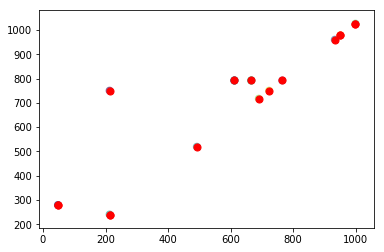

In [56]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
df = DataFrame(df_test,columns=["start_cut_DNA","end_cut_DNA"])
kmeans = KMeans(n_clusters=cluster_size).fit(df)
centroids = kmeans.cluster_centers_
plt.scatter(df["start_cut_DNA"], df["end_cut_DNA"], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [57]:
print(kmeans.labels_)

[ 2  2  6  0  5  4  4  4  4  7  7  7  9 10  1  3 11  8]


In [58]:
#data = pd.read_csv('filename')
#km = KMeans(n_clusters=5).fit(data)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_rc.index.values
cluster_map['cluster'] = kmeans.labels_

In [ ]:
# merge dataframes
df_kmeans = pd.merge(right=df_rc, right_index=True, left=cluster_map, left_index=True)


In [ ]:
df_kmeans.columns

In [ ]:
df_kmeans.drop(labels=['data_index', 'index',\
                       'start_DNA_w_padding', 'end_DNA_w_padding','length_DNA_w_padding',\
                       'Clustered','Size_of_gene','IDT_price',
                      'start_cut_DNA','end_cut_DNA','Cluster_name'], axis=1,inplace=True)

In [ ]:
df_kmeans.columns

In [ ]:
nr_clusters = list(set(kmeans.labels_))
df_kmeans['start_cut_DNA'] = 0
df_kmeans['end_cut_DNA'] = 0
df_kmeans['Size_of_gene'] = 0
df_kmeans['Cluster_name'] = ""

for cluster_ in nr_clusters:
    # get each cluster
    subcluster = df_kmeans[df_kmeans['cluster'] == cluster_]
    # print(subcluster)
    # start cut DNA
    mn_ = min(subcluster['start_DNA'])
    # end cut DNA
    mx_ = max(subcluster['end_DNA'])
    # size of gene
    length_ = mx_-mn_
    # cluster name
    clustername_ = "Cluster_"+str(mn_)+"_"+str(mx_)+"_cluster_nr_"+str(cluster_)
    for i in df_kmeans.index:
        if(df_kmeans.iloc[i,df_kmeans.columns.get_loc('cluster')] == cluster_):
            
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('start_cut_DNA')] = mn_ - bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('end_cut_DNA')] = mx_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Size_of_gene')] = length_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Cluster_name')]= clustername_

In [ ]:
df_kmeans.head()

In [ ]:
# Calculate price
df_kmeans["IDT_price"] = df_kmeans["Size_of_gene"].apply(get_price)
print("The price of the order is: ",df_kmeans["IDT_price"].sum())
print("Number of unique cluster: ", len(df_kmeans["Cluster_name"].unique()))
tmp = df_kmeans.groupby("Cluster_name").count()
print("Size of the different clusters: ",tmp["VarName"] )

In [ ]:
df_kmeans.to_excel("20190614_gene_above_1000.xlsx")

In [ ]:
df1 = pd.read_excel("20190614_gene_below_1000.xlsx")
df2 = pd.read_excel("20190614_gene_above_1000.xlsx")
dftot = pd.concat([df1,df2],axis=0)
dftot.reset_index(inplace=True)

In [ ]:
dftot.to_excel("20190614_elanco_DNA_68variants.xlsx")

In [ ]:
def write_fasta_file_w_variants(df):
    lengt = []
    with open("20190614_elannco_variants.fasta",'w') as f:
        for varname, dnaseq, st, end in zip(df["VarName"],df["seq(DNA)"],df["start_cut_DNA"],df["end_cut_DNA"]):
            f.write(varname+"\n")
            lengt.append(len(preseq+dnaseq[st:end]+postseq))
            f.write(preseq+dnaseq[st:end]+postseq+"\n")
    return lengt
a = write_fasta_file_w_variants(dftot)